In [1]:
from __future__ import annotations
from dataclasses import dataclass

import jax
import jax.numpy as jnp
from jax.tree_util import register_dataclass
import jaxtyping

import hodel.dismech as dismech

jax.config.update("jax_enable_x64", True)

geom = dismech.Geometry(
    rod_r0=0.001,
    shell_h=0,
)

mat = dismech.Material(
    density=1200,
    youngs_rod=2e6,
    youngs_shell=0,
    poisson_rod=0.5,
    poisson_shell=0,
)

"""# TODO: Figure out how sim params works for HoDEL
sim_params = dismech.SimParams(
    max_iter=30,
    tol=1e-4,
    ftol=1e-4,
    dtol=1e-2,
)"""


mesh = dismech.Mesh.from_txt("rod.txt")

top, state, mass, K, truth_triplets = dismech.from_legacy_custom(
    mesh, geom, mat, dismech.ParametrizedDERTriplet
)
assert type(truth_triplets) is dismech.ParametrizedDERTriplet

In [2]:
import hodel


def get_indices(
    q: jax.Array,
    top: dismech.Connectivity,
    fixed_nodes: jax.Array | None = None,
    fixed_edges: jax.Array | None = None,
) -> tuple[jax.Array, jax.Array]:
    nodes = (
        jnp.array([]) if fixed_nodes is None else dismech.map_node_to_dof(fixed_nodes)
    )
    edges = jnp.array([]) if fixed_edges is None else top.edge_dofs[0] + fixed_edges
    idx_b = jnp.union1d(nodes, edges)
    return idx_b, jnp.setdiff1d(jnp.arange(q.shape[0]), idx_b)


idx_b, idx_f = get_indices(
    state.q, top, jnp.array([0, 1, 2, 18, 19, 20]), jnp.array([0, 1, 18, 19])
)


@register_dataclass
@dataclass(frozen=True)
class TripletAux:
    """parametrized external force."""

    top: dismech.Connectivity  # for state.update()
    idx_f: jax.Array
    idx_b: jax.Array


def get_gravity(mass: jax.Array, g: jax.Array = jnp.array([0.0, 0.0, -9.81])):
    return mass * jnp.concat(
        [
            jnp.tile(g, mesh.nodes.shape[0]),
            jnp.zeros(mesh.edges.shape[0]),
        ]
    )


def get_W(lambda_: jax.Array, aux: TripletAux):
    """Just gravity."""
    return get_gravity(mass)[aux.idx_f]


def fixed_0(lambda_: jax.Array, aux: TripletAux) -> jax.Array:
    """Compress and contort."""
    return state.q[aux.idx_b] + lambda_ * jnp.concat(
        [
            jnp.array([0.02, 0.0, 0, 0.02, 0.0, 0, 0.02, 0.0, 0]),
            jnp.zeros(aux.idx_b.shape[0] - 13),
            jnp.array([1.0, 1.0, 0.0, 0.0]),
        ]
    )


def get_q(xf: jax.Array, xb: jax.Array, aux: TripletAux) -> jax.Array:
    """Helper to construct q from xf and xb."""
    q = jnp.empty((aux.idx_f.shape[0] + aux.idx_b.shape[0]), xf.dtype)
    return q.at[aux.idx_f].set(xf).at[aux.idx_b].set(xb)


def update_state(
    xf: jax.Array, xb: jax.Array, aux: TripletAux, carry: dismech.StaticState
) -> dismech.StaticState:
    """Construct q from xf and xb and update state."""
    q = get_q(xf, xb, aux)
    carry_new = carry.update(q, aux.top)
    return carry_new

def get_energy_fn(triplets):
    def get_batch_energy(
        xf: jax.Array,
        xb: jax.Array,
        Theta: jaxtyping.PyTree,
        aux: TripletAux,
        carry: dismech.StaticState,
    ) -> jax.Array:
        q = get_q(xf, xb, aux)
        state = carry.update(q, aux.top)
        return jnp.sum(jax.vmap(lambda t: t.get_energy(state, Theta))(triplets))
    return get_batch_energy

xf0 = state.q[idx_f]
aux = TripletAux(top, idx_f, idx_b)
truth_sim = hodel.HODEL(
    get_energy_fn(truth_triplets), get_W_fn=get_W, get_xb_fn=fixed_0, carry_fn=update_state
)

In [3]:
lambdas = jnp.linspace(0, 1.0, 100)
xf_stars = truth_sim.solve(lambdas, xf0, K, aux, state)
xb_stars = jax.vmap(fixed_0, (0, None))(lambdas, aux)
qs = jax.vmap(get_q, (0, 0, None))(xf_stars, xb_stars, aux)
dismech.animate(lambdas, qs, top)

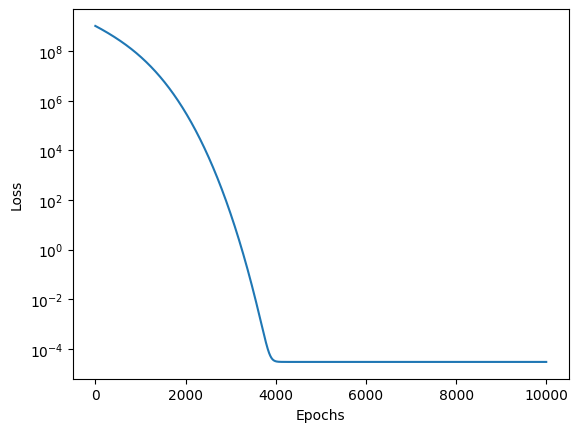

True Theta: [6.28318531e+00 6.28318531e+00 1.57079633e-06 1.57079633e-06
 1.04719755e-06]
Theta0: [0.41845711 0.21629545 0.96532146 0.57450053 0.53222649]
Warm Theta: [1.36633838e+00 1.16417672e+00 3.63066286e-07 3.74497921e-07
 2.32528849e-07]


In [4]:
import optax
import matplotlib.pyplot as plt

lambdas = jnp.linspace(0, 1, 100)
key = jax.random.PRNGKey(0)
Theta0 = jax.random.uniform(key, [5])
lr = 1e-3
nepochs = 10000
schedule = optax.cosine_decay_schedule(init_value=lr, decay_steps=nepochs // 2, alpha=1e-1)

bounded_optim = optax.chain(
    optax.adam(lr),
    optax.keep_params_nonnegative()
)
warm_Theta, L = truth_sim.learn(
    lambdas,
    xf0,
    xf_stars,
    Theta0,
    aux,
    state,
    optim=bounded_optim,
    nepochs=nepochs,
    method=hodel.Method.Residual,
)

plt.plot(L)
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

print("True Theta:", K)
print("Theta0:", Theta0)
print("Warm Theta:", warm_Theta)

In [5]:
lambdas = jnp.linspace(0, 1.0, 100)
xf_test = truth_sim.solve(lambdas, xf0, warm_Theta, aux, state, config=hodel.SolverConfig(nsteps=10))
xb_star = jax.vmap(fixed_0, (0, None))(lambdas, aux)
qs = jax.vmap(get_q, (0, 0, None))(xf_test, xb_star, aux)
dismech.animate(lambdas, qs, top)

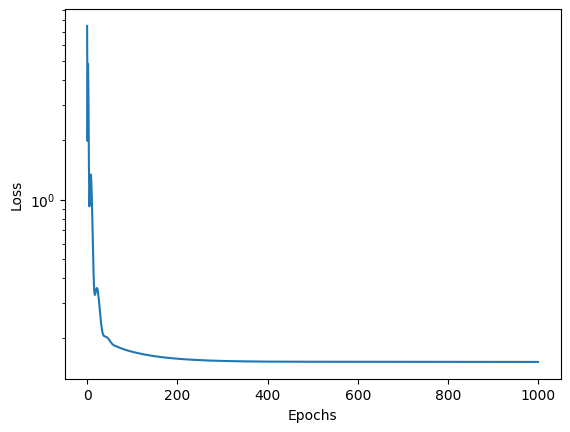

True Theta: [6.28318531e+00 6.28318531e+00 1.57079633e-06 1.57079633e-06
 1.04719755e-06]
Warm Theta:  [1.36633838e+00 1.16417672e+00 3.63066286e-07 3.74497921e-07
 2.32528849e-07]
Final Theta: [2.65975508e+00 1.85369153e+00 3.45976965e-07 3.02821185e-07
 2.05060161e-06]


In [9]:
@register_dataclass
@dataclass(frozen=True)
class LogTriplet(dismech.Triplet):
    def get_K(self, del_strain: jax.Array, Theta: jaxtyping.PyTree) -> jax.Array:
        return jnp.diag(warm_Theta * jnp.exp(Theta))

_, _, _, _, triplets = dismech.from_legacy_custom(
    mesh, geom, mat, LogTriplet
)
assert type(triplets) is LogTriplet
sim = hodel.HODEL(
    get_energy_fn(triplets), get_W_fn=get_W, get_xb_fn=fixed_0, carry_fn=update_state
)
nepochs = 1000
lr = 1e-1
schedule = optax.cosine_decay_schedule(init_value=lr, decay_steps=nepochs // 2, alpha=1e-2)
optim = optax.chain(
    #optax.clip(0.1),
    optax.adam(schedule)
)

final_Theta, L = sim.learn(
    lambdas,
    xf0,
    xf_stars,
    warm_Theta,
    aux,
    state,
    optim=optim,
    nepochs=nepochs,
    method=hodel.Method.Minimization,
    config=hodel.SolverConfig(nsteps=10)
)

plt.plot(L)
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

print("True Theta:", K)
#print("Final Theta:", final_Theta)
print("Warm Theta: ", warm_Theta)
print("Final Theta:", jnp.diag(triplets.get_K(jnp.zeros(0), final_Theta)))

Hessian Shape: (61, 61)
Non-zero elements: 507
Density: 13.63%
Maximum Bandwidth: 46
Hessian appears dense.


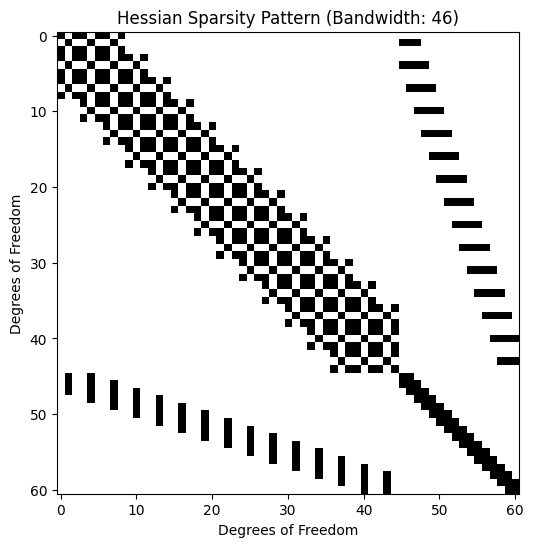

In [7]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt


def analyze_hessian_sparsity(x_sample, hessian_fn, threshold=1e-10):
    """
    Computes the Hessian at a sample point and analyzes its sparsity.
    """
    # 1. Compute the dense Hessian
    H = hessian_fn(x_sample)

    # 2. Create a binary mask of non-zero entries
    # We use a threshold to ignore numerical noise/epsilon
    mask = jnp.abs(H) > threshold

    # 3. Calculate bandwidth
    # Find the indices (i, j) where H[i, j] is non-zero
    indices = jnp.argwhere(mask)
    if indices.size == 0:
        print("Hessian is empty/zero.")
        return

    # Bandwidth = max(|i - j|)
    bandwidth = jnp.max(jnp.abs(indices[:, 0] - indices[:, 1]))

    print(f"Hessian Shape: {H.shape}")
    print(f"Non-zero elements: {jnp.sum(mask)}")
    print(f"Density: {100 * jnp.mean(mask):.2f}%")
    print(f"Maximum Bandwidth: {bandwidth}")

    if bandwidth < H.shape[0] / 2:
        print(f"CONFIRMED: Hessian is banded with bandwidth {bandwidth}")
    else:
        print("Hessian appears dense.")

    # 4. Visualize
    plt.figure(figsize=(6, 6))
    plt.imshow(mask, cmap="binary")
    plt.title(f"Hessian Sparsity Pattern (Bandwidth: {bandwidth})")
    plt.xlabel("Degrees of Freedom")
    plt.ylabel("Degrees of Freedom")
    plt.show()


# Usage:
xb = sim.get_xb(lambdas[0], aux)
analyze_hessian_sparsity(
    xf_stars[0], lambda x: jax.hessian(sim.get_energy, 0)(x, xb, final_Theta, aux, state)
)

In [10]:
lambdas = jnp.linspace(0, 1.0, 100)
xf_test = sim.solve(lambdas, xf0, final_Theta, aux, state, config=hodel.SolverConfig(nsteps=10))
xb_star = jax.vmap(fixed_0, (0, None))(lambdas, aux)
qs = jax.vmap(get_q, (0, 0, None))(xf_test, xb_star, aux)
dismech.animate(lambdas, qs, top)